#Synchrony of spike trains

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set(style='whitegrid')

In [4]:
def loadfile(filepath, neurons):
    arr  = np.loadtxt(filepath, dtype='float', delimiter=",")
    timesteps = arr[-1, 0]
    spikes = sp.coo_matrix((arr[:,2], (arr[:,0]-1, arr[:, 1]-1)), (timesteps, neurons)).tocsr()
    return spikes

In [5]:
def loadReplenish(filepath, name):
    df = pd.read_csv(filepath, index_col='time', names=['time', name])
    return df

In [6]:
def plotHist(data, xmin, xmax, nbins):
    hist, bins = np.histogram(data, range=(xmin, xmax), bins=nbins, density=True)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()

In [7]:
def plotHistDiff(data1, data2, xmin, xmax, nbins):
    hist1, bins = np.histogram(data1, range=(xmin, xmax), bins=nbins, density=True)
    hist2, bins = np.histogram(data2, range=(xmin, xmax), bins=nbins, density=True)
    hist = hist1 - hist2
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()

In [8]:
def V(trains):
    [T, N] = trains.shape
    return trains.sum(axis=1)/N

In [9]:
def Vvar(trains):
    [T, N] = trains.shape
    v = V(trains)
    a = np.sum(np.square(v))/T
    b = np.square(np.sum(v)/T)
    return a-b

In [10]:
def Vivar(trains):
    [T, N] = trains.shape
    trains = trains.tocsc()
    a = trains.power(2).sum(axis=0)/T
    b = np.square(trains.sum(axis=0)/T)
    return a-b    

In [11]:
def syncMeasure(v_var, vi_var, N):
    return v_var/(vi_var.sum()/N)

In [12]:
def calcSync(trains):
    [T, N] = trains.shape
    v_var  = Vvar(trains)
    vi_var = Vivar(trains)
    return syncMeasure(v_var, vi_var, N)

In [13]:
def slidingSync(trains, window, step_size):
    [T, N] = trains.shape
    steps = int(T/step_size)
    sync = np.empty((steps, 2))
    step = 0
    while(step < steps):
        t0 = step*step_size
        tf = t0+window
        if(tf > T):
            tf = T
        sync[step, :] = [t0, calcSync(trains[t0:tf, :])]
        step += 1
    return sync

In [14]:
neurons = 7520
high = loadfile("../../BrainPowerLogs/SampleLogs/Long/HighConst_Firing.csv", neurons)
med  = loadfile("../../BrainPowerLogs/SampleLogs/Long/MediumConst_Firing.csv", neurons)
low  = loadfile("../../BrainPowerLogs/SampleLogs/Long/LowConst_Firing.csv", neurons)
keto = loadfile("../../BrainPowerLogs/SampleLogs/Long/Keto_Firing.csv", neurons)
gluco  = loadfile("../../BrainPowerLogs/SampleLogs/Long/Gluco_Firing.csv", neurons)
hypo  = loadfile("../../BrainPowerLogs/SampleLogs/Long/Hypo_Firing.csv", neurons)

In [15]:
repHigh = loadReplenish("../../BrainPowerLogs/SampleLogs/Long/HighConst_Replenish.csv", 'high')
repMed = loadReplenish("../../BrainPowerLogs/SampleLogs/Long/MediumConst_Replenish.csv", 'med')
repLow = loadReplenish("../../BrainPowerLogs/SampleLogs/Long/LowConst_Replenish.csv", 'low')
repKeto = loadReplenish("../../BrainPowerLogs/SampleLogs/Long/Keto_Replenish.csv", 'keto')
repGluco = loadReplenish("../../BrainPowerLogs/SampleLogs/Long/Gluco_Replenish.csv", 'gluco')
repHypo = loadReplenish("../../BrainPowerLogs/SampleLogs/Long/Hypo_Replenish.csv", 'hypo')

In [16]:
replenish = pd.concat([repHigh, repMed, repLow, repKeto, repGluco, repHypo], axis=1)
temp = pd.DataFrame({'high':[0.08], 'med': [0.05], 'low': [0.02], 'keto': [0.07], 'gluco': [0.08], 'hypo': [0.05]}, index=[0])
replenish = pd.concat([temp, replenish])

(0.00079284341253508584, 0.0020799103266414963, 0.0022543576720533698, 0.0022827480000506741, 0.0012837119805948064, 0.0017482086285749616)


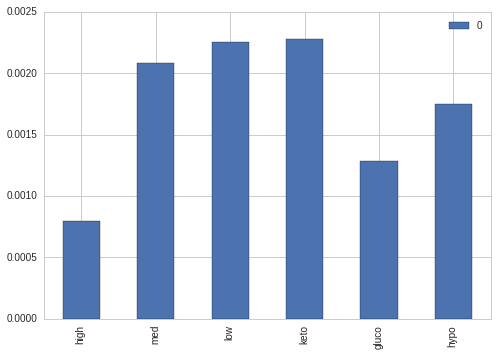

In [17]:
sHigh  = calcSync(high)
sMed   = calcSync(med)
sLow   = calcSync(low)
sKeto  = calcSync(keto)
sGluco = calcSync(gluco)
sHypo  = calcSync(hypo)
#synchrony measure over whole timeseries 
print(sHigh, sMed, sLow, sKeto, sGluco, sHypo)
pd.DataFrame([sHigh, sMed, sLow, sKeto, sGluco, sHypo],
            index=['high', 'med', 'low', 'keto', 'gluco', 'hypo']).plot(kind='bar')

In [18]:
#calculate synchrony over a sliding interval with a window of 300 and shifted by 100 timesteps
slideHigh  = slidingSync(high, 300, 100)
slideMed   = slidingSync(med, 300, 100)
slideLow   = slidingSync(low, 300, 100)
slideKeto  = slidingSync(keto, 300, 100)
slideGluco = slidingSync(gluco, 300, 100)
slideHypo  = slidingSync(hypo, 300, 100)
slidedf    = pd.DataFrame({'high': slideHigh[:,1], 'med': slideMed[:, 1], 'low': slideLow[:, 1], 
                           'keto': slideKeto[:,1], 'gluco': slideGluco[:, 1], 'hypo': slideHypo[:, 1]}, 
                         index=slideHigh[:, 0], columns=['high', 'med', 'low', 'keto', 'gluco', 'hypo'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f01c82649d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f01cbf2b690>], dtype=object)

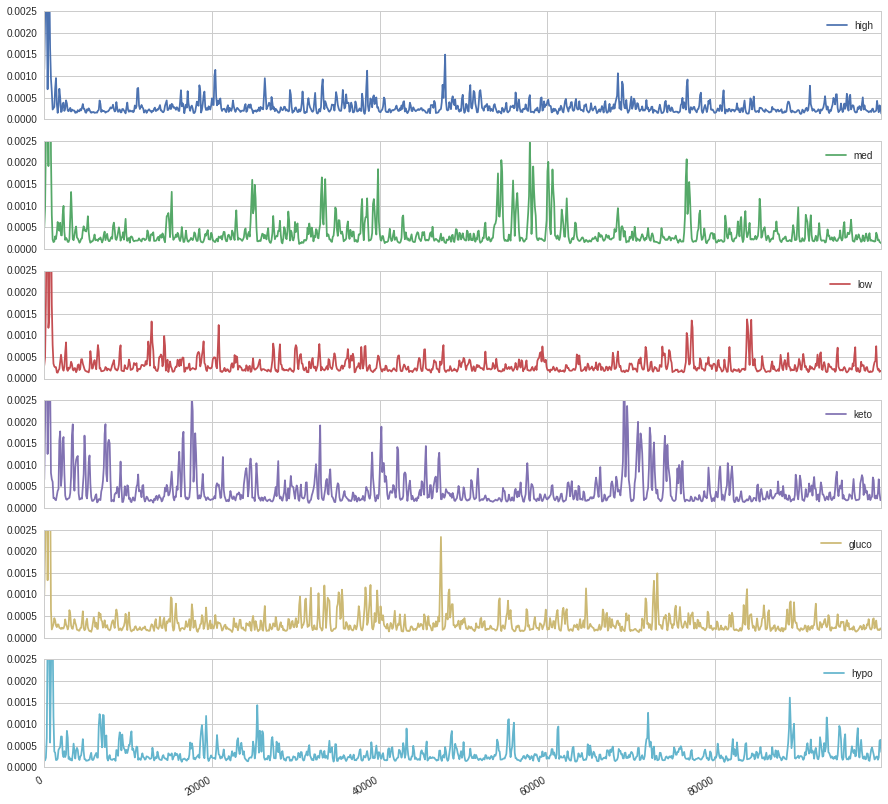

In [19]:
slidedf.plot(subplots=True, figsize=(15,15), ylim=(0, 0.0025))

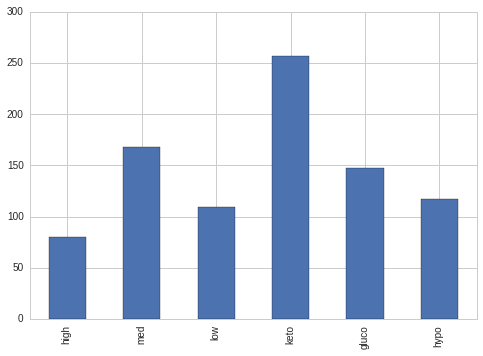

In [20]:
#number of times synchrony is above sync_thresh
sync_thresh = 0.0005
(slidedf >= sync_thresh).sum().plot(kind='bar')

In [21]:
#perform same analysis on fMRI data
bioNeurons = 497
bioKeto = loadfile("./SampleLogs_LMPMC/BPF_PP5_Keto.csv", neurons)
bioGluco = loadfile("./SampleLogs_LMPMC/BPF_PP5_Gluco.csv", neurons)
bioHypo = loadfile("./SampleLogs_LMPMC/BPF_PP5_Hypo.csv", neurons)

(0.0045821084956733501, 0.0037586230272467097, 0.0054516945847829772)


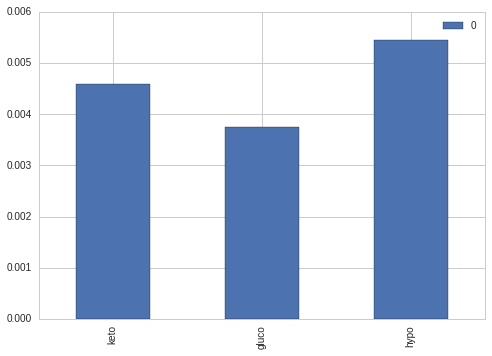

In [22]:
bsKeto  = calcSync(bioKeto)
bsGluco = calcSync(bioGluco)
bsHypo  = calcSync(bioHypo)
#synchrony measure over whole timeseries 
print(bsKeto, bsGluco, bsHypo)
pd.DataFrame([bsKeto, bsGluco, bsHypo],
            index=['keto', 'gluco', 'hypo']).plot(kind='bar')

In [23]:
#calculate synchrony over a sliding interval with a window of 300 and shifted by 100 timesteps
bslideKeto  = slidingSync(bioKeto, 50, 10)
bslideGluco = slidingSync(bioGluco, 50, 10)
bslideHypo  = slidingSync(bioHypo, 50, 10)
bslidedf    = pd.DataFrame({'keto': bslideKeto[:,1], 'gluco': bslideGluco[:, 1], 'hypo': bslideHypo[:, 1]}, 
                         index=bslideKeto[:, 0], columns=['keto', 'gluco', 'hypo'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f01d5a0bd50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f01d413f590>], dtype=object)

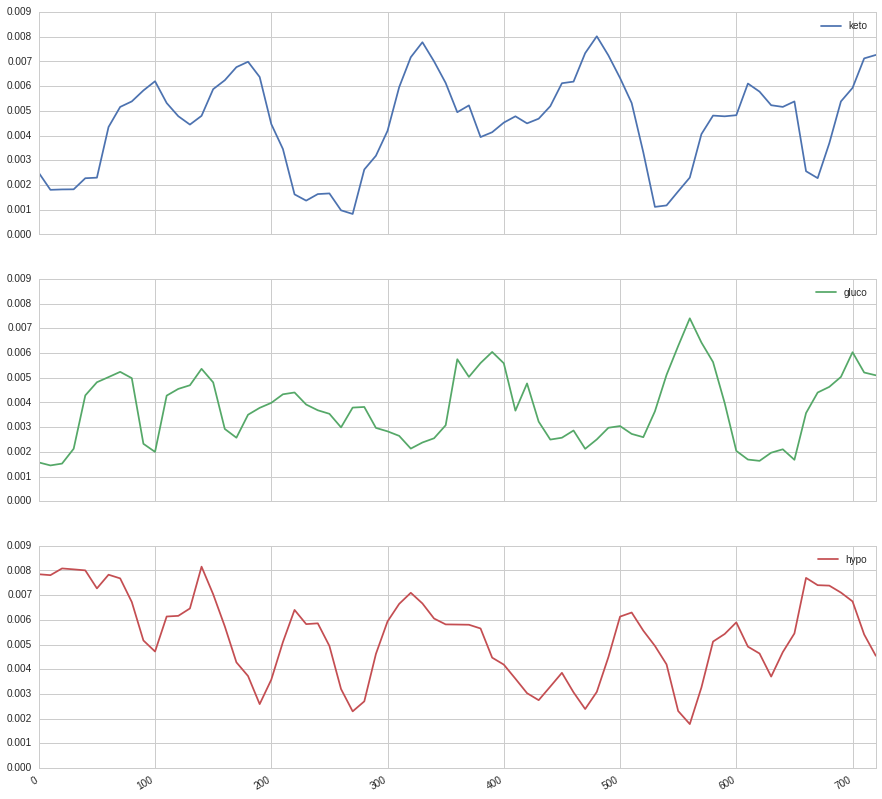

In [24]:
bslidedf.plot(subplots=True, figsize=(15,15), ylim=(0, 0.009))

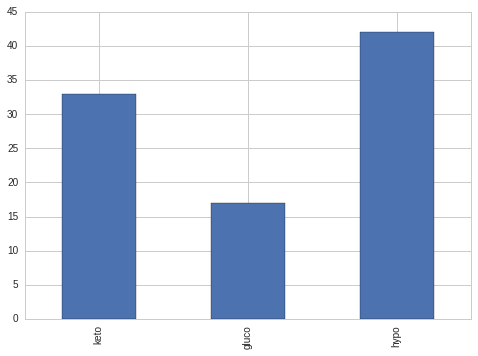

In [25]:
#number of times synchrony is above sync_thresh
bsync_thresh = 0.005
(bslidedf >= bsync_thresh).sum().plot(kind='bar')